# 케라스로 SQUAD 구현하기 

구글 Bert Base 모델 다운 받기. 
이번 분석에서 쓰이는 모델은 __Bert-Bae-Uncased__

In [1]:
import os
import zipfile
import shutil

# 버트 모델 다운로드
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

# colab에 bert폴더 생성
if "bert" not in os.listdir() :
  os.makedirs("bert")
else : 
  pass

# 다운받은 Bert 모형을 bert 폴더에 압축 풀기 
bert_zip = zipfile.ZipFile('uncased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')

bert_zip.close()

--2020-03-09 07:49:39--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 2404:6800:4008:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  76.3MB/s    in 5.5s    

2020-03-09 07:49:45 (71.0 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [0]:
# 폴더를 통째로 복사하는 함수 생성
# 셸 유틸리티 모듈.
# 원래 압축이 풀린 폴더는 "bert/uncased_L-12_H-768_A-12" 이지만
# 분석에 편리하게 쓰기 위해 bert 폴더로 버트 모델을 이동시키자

def copytree(src, dst, symlinks = False, ignore = None) :
  for item in os.listdir(src) :
    s = os.path.join(src, item)
    d = os.path.join(dst, item)
    if os.path.isdir(s) :
      shutil.copytree(s, d, symlinks, ignore) # copytree : 디렉터리를 복사, 원본이 폴더가 아닌 파일이면 에러를 발생
    else :
      shutil.copy2(s, d)

copytree("bert/uncased_L-12_H-768_A-12", "bert")


In [3]:
# 이번 실습에서 사용할 데이터 다운로드(SQuAD v1.1) Train and dev set
!wget https://raw.githubusercontent.com/nate-parrott/squad/master/data/train-v1.1.json
!wget https://raw.githubusercontent.com/nate-parrott/squad/master/data/dev-v1.1.json

--2020-03-09 07:49:53--  https://raw.githubusercontent.com/nate-parrott/squad/master/data/train-v1.1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [text/plain]
Saving to: ‘train-v1.1.json’

train-v1.1.json     100%[===================>]  28.88M   120MB/s    in 0.2s    

2020-03-09 07:49:57 (120 MB/s) - ‘train-v1.1.json’ saved [30288272/30288272]

--2020-03-09 07:49:58--  https://raw.githubusercontent.com/nate-parrott/squad/master/data/dev-v1.1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4854279 (4.6M) [text/pl

In [42]:
# 구글 드라이브와 Colab을 연동
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import tensorflow as tf

import pandas as pd
import numpy as np
import re
import pickle # 파이썬 파일 읽기 기본모듈

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

from keras import backend as K
from keras.layers import Layer


# codecs(스트리밍 인코더/디코더) python 기본 모듈을 이용하면 파일을 조금씩 읽을 수 있고, 메모리에도 약간의 유니코드 데이터만 올릴수 있다.
import codecs 
from tqdm import tqdm
import json



In [0]:
import warnings
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

keras 에서 Bert 활용을 수비게 만들어 주는 keras-bert를 설치한다. 그리고 Adam optimizer 의 수정판인 keras-radam 모듈또한 임포트 한다.
keras-radam은 모델을 훈련시킬 때, learning_rate를 점진적으로 목표값까지 올려주는 방법으로 훈련과정을 안정화 시켜주는 optimizer 이다. 

In [45]:
!pip install keras-bert
!pip install keras-radam

In [0]:
# keras-bert 라이브러리에서 버트 모형 활용에 필요한 모듈들을 import 
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

SQUAD JSON파일을 PANDAS DATAFRAME으로 만들어주는 함수를 정의합니다.
출처 : https://www.kaggle.com/sanjay11100/squad-stanford-q-a-json-to-pandas-dataframe

In [0]:
def squad_json_to_dataframe_train(input_file_path, 
                                  record_path = ['data','paragraphs','qas','answers'],
                                  verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [48]:
# SQUAD 데이터를 Pandas dataframe 형식으로 로드 
train = squad_json_to_dataframe_train("train-v1.1.json")

Reading the json file
processing...
shape of the dataframe is (87599, 6)
Done


In [49]:
train.head()

,index,question,context,answer_start,text,c_id
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",515,Saint Bernadette Soubirous,0
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",188,a copper statue of Christ,0
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",279,the Main Building,0
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",381,a Marian place of prayer and reflection,0
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",92,a golden statue of the Virgin Mary,0


In [50]:
# context의 길이를 알려주는 칼럼 생성
train['context_len'] = train['context'].str.len()
# 질문의 길이가 10 미만인 데이터 확인
# 질문의 길이가 10 미만이면 이상한 데이터일 가능성 높음
train.loc[train['question'].str.len() <= 10].head(10)

,index,question,context,answer_start,text,c_id,context_len
16818,56e6eb396fe0821900b8ec24,k,"Nanjing ( listen; Chinese: 南京, ""Southern Capit...",232,ks,3731,1621
16819,56e6eb396fe0821900b8ec25,j,"Nanjing ( listen; Chinese: 南京, ""Southern Capit...",18,Ch,3731,1621
16820,56e6eb396fe0821900b8ec26,n,"Nanjing ( listen; Chinese: 南京, ""Southern Capit...",2,n,3731,1621
16821,56e6eb396fe0821900b8ec27,b,"Nanjing ( listen; Chinese: 南京, ""Southern Capit...",144,b,3731,1621
16822,56e6eb396fe0821900b8ec28,v,"Nanjing ( listen; Chinese: 南京, ""Southern Capit...",108,v,3731,1621
38422,57262473271a42140099d4e9,dd,The Hellenistic period covers the period of an...,1102,yptian Se,8322,1194
38423,57262473271a42140099d4ea,dd,The Hellenistic period covers the period of an...,1185,Buddh,8322,1194
38424,57262473271a42140099d4eb,dd,The Hellenistic period covers the period of an...,915,m and E,8322,1194
38425,57262473271a42140099d4ec,dd,The Hellenistic period covers the period of an...,1185,Buddhism,8322,1194
38426,57262473271a42140099d4ed,d,The Hellenistic period covers the period of an...,1090,the Gre,8322,1194


In [0]:
# 질문의 길이가 10미만일 경우 데이터를 삭제
train = train.loc[train['question'].str.len() >= 10].reset_index(drop = True)

- bert 훈련을 위한 사전 설정을 합니다. SEQ_LEN은 문장의 최대 길이입니다. SEQ_LEN 보다 문장의 길이가 작다면 남은 부분은 0이 채워지고, 만약에 SEQ_LEN보다 문장 길이가 길다면 SEQ_LEN을 초과하는 부분이 잘리게 됩니다.
본 문제에서는 메모리 문제 등으로 384로 정했습니다.
- BATCH_SIZE는 메모리 초과 같은 문제를 방지하기 위해 작은 수인 10으로 정했습니다. 그리고 총 훈련 에포크 수는 2로 정했습니다. 학습율(LR;Learning rate)은 3e-5로 작게 정했습니다.
- pretrained_path는 bert 사전학습 모형이 있는 폴더를 의미합니다.
- 그리고 우리가 분석할 문장이 들어있는 칼럼의 제목인 document와 긍정인지 부정인지 알려주는 칼럼을 label로 정해줍니다

In [0]:
SEQ_LEN = 384
# 버트 인풋으로 들어갈 문장의 길이 입니다.
# 즉 Question + Context의 길이를 뜻합니다.
# 이번 예제에선 384로 정하였습니다.

BATCH_SIZE = 12
# 한번에 훈련할 배치 크기를 12로 하여 12개씩 묶음으로 훈련
EPOCHS =2
# 에폭수를 2로 하여 총 데이터를 2번만 훈련 시킴
LR=1.5e-5 
#학습율(Learning Rate)을 1.5e-5로 작게 설정, 파인튜닝이기 때문에 작게 설정해도 잘 돌아감

# 구글에서 다운 받은 Bert 모형이 들어가있는 폴더
pretrained_path = "bert"
# 버트 레이어에 관한 설정 된 파일, bert_config.json
config_path = os.path.join(pretrained_path, "bert_config.json")

# 구글에서 다운 받은 Bert 모델이 있는 폴더 
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
# Bert에 쓸 어휘 뭉치들을 저장하고 이쓴ㄴ 파일 
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "context"
# context를 포함하고 있는 열의 이름
QUESTION_COLUMN = "question"
# question을 포함하고 있는 열의 이름
TEXT = "text"
# text(정답)을 포함하고 있는 열의 이름

vocab.txt에 있는 단어에 인덱스를 추가해주는token_dict 라는 딕셔너리를 생성 합니다. 우리가 분석할 문장이 토큰화가 되고, 그 다음에는 인덱스(숫자)로 변경되어서 버트 신경망에 인풋으로 들어가게 됩니다. 

In [0]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [58]:
# 단어에 대응하는 숫자가 넘버링 된 것을 확인 가능
token_dict

{'[PAD]': 0,
 '[unused0]': 1,
 '[unused1]': 2,
 '[unused2]': 3,
 '[unused3]': 4,
 '[unused4]': 5,
 '[unused5]': 6,
 '[unused6]': 7,
 '[unused7]': 8,
 '[unused8]': 9,
 '[unused9]': 10,
 '[unused10]': 11,
 '[unused11]': 12,
 '[unused12]': 13,
 '[unused13]': 14,
 '[unused14]': 15,
 '[unused15]': 16,
 '[unused16]': 17,
 '[unused17]': 18,
 '[unused18]': 19,
 '[unused19]': 20,
 '[unused20]': 21,
 '[unused21]': 22,
 '[unused22]': 23,
 '[unused23]': 24,
 '[unused24]': 25,
 '[unused25]': 26,
 '[unused26]': 27,
 '[unused27]': 28,
 '[unused28]': 29,
 '[unused29]': 30,
 '[unused30]': 31,
 '[unused31]': 32,
 '[unused32]': 33,
 '[unused33]': 34,
 '[unused34]': 35,
 '[unused35]': 36,
 '[unused36]': 37,
 '[unused37]': 38,
 '[unused38]': 39,
 '[unused39]': 40,
 '[unused40]': 41,
 '[unused41]': 42,
 '[unused42]': 43,
 '[unused43]': 44,
 '[unused44]': 45,
 '[unused45]': 46,
 '[unused46]': 47,
 '[unused47]': 48,
 '[unused48]': 49,
 '[unused49]': 50,
 '[unused50]': 51,
 '[unused51]': 52,
 '[unused52]': 53,

- Bert의 토큰화는 단어를 분리하는 토큰화 방식이다. wordpiece 방식이라고 한다. 이는 한국어를 형태소로 꼭 변환해야 할 문제를 해결해주며, 의미가 있는 단어는 밀접하게 연관이 되게 하는 장점까지 갖추고 있다.  
__ex)__ 짜파구리, 짜파게티 등 단순 Word2Vec는 이런 기능이 없다.

- 단어의 첫 시작은 ##가 붙지 않지만, 단어에 포함되면서 단어의 시작이 아닌 부분에는 ##가 붙는것이 특징

In [0]:
# 이전에 한국어 형태소 분석기를 활용하여 Tokenizer를 돌려보았는데 딱히 좋은 퍼포먼스를 보이지 못하였다. 이유는??
# 단어와 넘버링된 숫자를 활용하여 Tokenizer 생성
tokenizer = Tokenizer(token_dict)

In [60]:
print(tokenizer.tokenize("Keras is Really fun."),"\n")
print(tokenizer.tokenize("we can manipulate AI."))
print(tokenizer.tokenize("bedroom nightgown backbone greenhouse greengouse bluebird bluebee"))

# uncased 모델이라 corpus의 대소문자를 소문자로 바꾼후 tokenize 해준다. 
# 생각보다 wordpiece 단위로 잘 잘라주지는 못하는듯,,?

['[CLS]', 'ke', '##ras', 'is', 'really', 'fun', '.', '[SEP]'] 

['[CLS]', 'we', 'can', 'manipulate', 'ai', '.', '[SEP]']
['[CLS]', 'bedroom', 'night', '##go', '##wn', 'backbone', 'greenhouse', 'green', '##go', '##use', 'blue', '##bird', 'blue', '##bee', '[SEP]']


In [0]:
# token dict의 key 값과 value 값을 바꾼 reverse_token_dict를 정의합니다.
# 추후에 쓰기 위해 token_dict를 반대로 한 딕셔너리를 생성
# {숫자 : 단어, 숫자 : 단어}의 방식임
reverse_token_dict = {v : k for k, v in token_dict.items()}

In [62]:
reverse_token_dict

{0: '[PAD]',
 1: '[unused0]',
 2: '[unused1]',
 3: '[unused2]',
 4: '[unused3]',
 5: '[unused4]',
 6: '[unused5]',
 7: '[unused6]',
 8: '[unused7]',
 9: '[unused8]',
 10: '[unused9]',
 11: '[unused10]',
 12: '[unused11]',
 13: '[unused12]',
 14: '[unused13]',
 15: '[unused14]',
 16: '[unused15]',
 17: '[unused16]',
 18: '[unused17]',
 19: '[unused18]',
 20: '[unused19]',
 21: '[unused20]',
 22: '[unused21]',
 23: '[unused22]',
 24: '[unused23]',
 25: '[unused24]',
 26: '[unused25]',
 27: '[unused26]',
 28: '[unused27]',
 29: '[unused28]',
 30: '[unused29]',
 31: '[unused30]',
 32: '[unused31]',
 33: '[unused32]',
 34: '[unused33]',
 35: '[unused34]',
 36: '[unused35]',
 37: '[unused36]',
 38: '[unused37]',
 39: '[unused38]',
 40: '[unused39]',
 41: '[unused40]',
 42: '[unused41]',
 43: '[unused42]',
 44: '[unused43]',
 45: '[unused44]',
 46: '[unused45]',
 47: '[unused46]',
 48: '[unused47]',
 49: '[unused48]',
 50: '[unused49]',
 51: '[unused50]',
 52: '[unused51]',
 53: '[unused52]',

## 버트 모형에 들어갈 인풋은 토큰, 세크먼트, 포지션 임베딩을 통해 구성됩니다.

버트에 인풋으로 들어가는 토큰은 문장을 토크나이징 한 후, 인덱스 번호를 매긴 것입니다.
세그먼트는 예를 들어 문장이 두 개가 있다면, 앞의 문장과 뒤의 문장을 구분하는 것입니다.
포지션 임베딩은 단순히 단어의 위치를 말합니다.
(포지션 임베딩은 딱히 결과에 영향을 주진 않는듯 하다,)


토큰, 세그먼트, 포지션을 인풋으로 버트 모형에 넣으면 기하학적인 문장 공간으로 임베딩이 됩니다.
그림을 보면 my dog is cute, he likes play ##ing 두 문장이 있는데요
SQUAD 문제에서는 첫번째 문장이 question, 두번째 문장이 context가 되고, 이 두 문장이 합쳐져서 하나의 문장으로 들어가게 됩니다.


![대체 텍스트](https://i.imgur.com/l9BTao3.png)

토큰화 과정을 위의 문장인 my dog is cute, he likes playing을 가지고 실험해보도록 하겠습니다.

In [21]:
print(tokenizer.tokenize("my dog is cute", "he likes playing"))
# 위에서도 말했지만 wordpiece 단위로 제대로 나누어주진 못하는듯 하다. playing을 그림예에서는 play + ##ing 로 잘라주지만 아래서는 그렇게 까지 잘르지는 못한다.

['[CLS]', 'my', 'dog', 'is', 'cute', '[SEP]', 'he', 'likes', 'playing', '[SEP]']


In [22]:
# 위에 토크나이즈 된 리스트가 숫자로 바뀜
print(tokenizer.encode("my dog is cute", "he likes playing"))
# 0이 앞 문장에 대한 segment, 1이 뒷 문장에 대한 segment임
# 버트 모델에 인풋 값으로 토크나이즈가 인덱스 된 리스트와 세그멘트 리스트가 들어가게 됨

# 101 은 시작  [CLS]
# 102 는 끝 [SEP]

([101, 2026, 3899, 2003, 10140, 102, 2002, 7777, 2652, 102], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1])


- 사전학습된 버트 모델의 인풋은 문장 토큰화가 숫자로 바뀐 것과, 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터가 들어갑니다. **이번 SQUAD 문제에서는, 첫번째 문장에 해당하는 질문(Question)에 세그먼트가 0, 두번째 문장에 해당하는 Context에 세그먼트가1, 패딩 부분에 세그멘트가 0**이 들어가게 되어, 문장의 전후관계를 구분하게 됩니다.
- 그리고 파인튜닝 시에는 문장 안에 일부 단어를 가리는 마스킹은 사용하지 않습니다.

In [23]:
print("Question : ", train.loc[0,'question'])
print("Context : ", train.loc[0,'context'])
print("Answer : ", train.loc[0,'text'])

Question :  To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Context :  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Answer :  Saint Bernadette Soubirous


In [24]:
print("Question : ", tokenizer.tokenize(train.loc[0,'question']))
print("Context : ", tokenizer.tokenize(train.loc[0,'context']))
print("Answer : ", tokenizer.tokenize(train.loc[0,'text']))

# SQUAD 문제에서 예측하는 실제 정답은 맨 첫 토큰인 saint와 맨 끝 토큰인 ##us의 위치를 맞추는 것임

Question :  ['[CLS]', 'to', 'whom', 'did', 'the', 'virgin', 'mary', 'allegedly', 'appear', 'in', '1858', 'in', 'lou', '##rdes', 'france', '?', '[SEP]']
Context :  ['[CLS]', 'architectural', '##ly', ',', 'the', 'school', 'has', 'a', 'catholic', 'character', '.', 'atop', 'the', 'main', 'building', "'", 's', 'gold', 'dome', 'is', 'a', 'golden', 'statue', 'of', 'the', 'virgin', 'mary', '.', 'immediately', 'in', 'front', 'of', 'the', 'main', 'building', 'and', 'facing', 'it', ',', 'is', 'a', 'copper', 'statue', 'of', 'christ', 'with', 'arms', 'up', '##rai', '##sed', 'with', 'the', 'legend', '"', 've', '##ni', '##te', 'ad', 'me', 'om', '##nes', '"', '.', 'next', 'to', 'the', 'main', 'building', 'is', 'the', 'basilica', 'of', 'the', 'sacred', 'heart', '.', 'immediately', 'behind', 'the', 'basilica', 'is', 'the', 'gr', '##otto', ',', 'a', 'marian', 'place', 'of', 'prayer', 'and', 'reflection', '.', 'it', 'is', 'a', 'replica', 'of', 'the', 'gr', '##otto', 'at', 'lou', '##rdes', ',', 'france', '

정답이 있는 위치는 어떻게 맞추는지?
SQUAD 같은 경우에는 context에 정답(text)을 포함하고 있다.
따라서 context와 text 둘 다 토크나이징 한 다음에 context 안에서 text의 위치를 찾아내면 된다.

엄밀히 말하면, text의 시작 토큰의 위치와, 끝 토큰의 위치를 맞추면 되는 것이다.

다만 text에서 [CLS]와 [SEP]을 제외하고 생각해야 한다.
[CLS]는 101, [SEP]은 102에 해당함.

In [25]:
#Context
print(tokenizer.encode(train.loc[0, 'context']))
#text(정답)
print(tokenizer.encode(train.loc[0, 'text']))

([101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052, 2012, 10223, 26371, 1010, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271, 1999, 8517, 1012, 2012, 1996, 2203, 1997, 1996, 2364, 3298, 1006, 1998, 1999, 1037, 3622, 2240, 2008, 8539, 2083, 1017, 11342, 1998, 1996, 2751, 8514, 1007, 1010, 2003, 1037, 3722, 1010, 2715, 2962, 6231, 1997, 2984, 1012, 102], [0, 0, 0, 0, 0, 0, 0, 

In [26]:
# 세그먼트를 제외하고 토크나이즈 된 것만 추출
context = tokenizer.encode(train.loc[0, 'context'])[0]
text = tokenizer.encode(train.loc[0, 'text'])[0]

print(context)
print(text)

[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052, 2012, 10223, 26371, 1010, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271, 1999, 8517, 1012, 2012, 1996, 2203, 1997, 1996, 2364, 3298, 1006, 1998, 1999, 1037, 3622, 2240, 2008, 8539, 2083, 1017, 11342, 1998, 1996, 2751, 8514, 1007, 1010, 2003, 1037, 3722, 1010, 2715, 2962, 6231, 1997, 2984, 1012, 102]
[101, 3002, 16595, 9648,

In [27]:
# text에서 [CLS]와 [SEP]에 해당하는 부분 제거
text.pop(0) # 첫 토크나이즈 제거
text.pop(-1) # 마지막 토크나이즈 제거
text

[3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271]

In [28]:
# 텍스트(정답)의 길이 계산
# context를 텍스트의 길이 만큼 슬라이딩 하면서 정답과 일치되는 부분을 찾는다
text_slide_len = len(text)
        
for j in range(0,(len(context))):  
  # exist_flag 변수는 context내에 정답이 존재하는지의 여부를 알려줌
  exist_flag = 0
  if text == context[j:j+text_slide_len]:
    # context 내에 정답의 시작 토큰 위치
    ans_start = j
    # context 내에 정답의 끝 토큰 위치
    ans_end = j + text_slide_len - 1
    # 정답을 찾았으면 exist_flag 변수를 1로 바꿈
    exist_flag = 1
    break

print("ans_start : {}, ans_end : {}".format(ans_start, ans_end))

ans_start : 114, ans_end : 121


In [29]:
# 정답은 context 내에 위취는 114,121 임을 알 수 있다.
print(context[114:121+1] == text)
print(context[114:121+1])

True
[3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271]


우리가 로드하였던 SQUAD 데이터를 버트 모형의 입력에 맞게 변형해주는 함수를 정의하도록 하겠습니다.
즉, BERT의 인풋으로 들어갈 함수를 정의하도록 하겠습니다.
87599개의 train 데이터를 한번에 입력할 수 있도록 bert의 인풋으로 바꿔줍니다.

방금 보셨다시피, 함수 내부에 tokenizer.encode 함수가 버트 모형을 토큰화해주고 토큰화 된 단어를 인덱스에 맞게 숫자로 바꿔주게 됩니다.
[CLS] 질문 [SEP] 문장 [SEP] 이런 방식으로 질문과 문장이 인풋으로 들어가게 됩니다. SEQ_LEN이 384로 지정되어 있어서 길이가 384가 넘는 인풋은 문장 부분이 잘려서 들어가게 됩니다.
그리고 question의 총 길이를 최대 64로 제한하였습니다. 즉 64 이상이면 질문의 길이가 64가 되도록 잘리게 됨

SQUAD 문제에서 문장(context) 내에 text(정답)이 포함된다고 미리 말씀 드렸는데요, 길이가 384가 넘는 인풋인 경우에 context 내에 정답을 포함하고 있는 context가 잘려서 정답을 포함하지 않는 경우가 생깁니다. 이번 실습에서는 이러한 경우의 인덱스를 del_list로 지정해서, 빼도록 하겠습니다. 


참고로 버트 인풋으로 들어가는 Question과 Context는
[CLS] Question [SEP] Context [SEP]의 구조를 가져야 합니다.

In [0]:
# data_df (train 데이터의 pandas_dataframe)을 받아서 Bert Input으로 변형해주는 함수 정의 
def convert_data(data_df) :
    global tokenizer
    indices, segments, target_start, target_end = [], [], [], []

    # tqdm python 진행 표시 바
    for i in tqdm(range(len(data_df))) :
        # que : question을 Bert input으로 들어갈 수 있게 토큰화 한 변수, tokenizer, encoder을 사용하면
        # 토큰화 된 리스트와, 세그먼트가 같이 나오는데 일단 토큰화 된 리스트만 사용

        # doc : context를 Bert Input 들어갈 수 있게 토큰화 한 변수
        que, _ = tokenizer.encode(data_df[QUESTION_COLUMN][i])
        doc, _ = tokenizer.encode(data_df[DATA_COLUMN][i])

        # 토큰화된 context의 맨 앞에 있는 [CLS]에 해당하는 101을 삭제
        doc.pop(0)

        # que_len, doc_len : 질문의 길이, context의 길이 
        que_len = len(que) 
        doc_len = len(doc) 

        # 만약 question의 길이가 64를 초과 하면,64로 잘라준다.

        if que_len > 64 :
          que = que[:63]
          # 질문의 끝이 [SEP] 이 되도록,  [SEP] 에 해당하는 102 CNRK
          que.append(102)

        # 버트 인풋으로 들어가는 토큰화된 리스트가 최대 길이인 384가 넘지 않도록 만들어 줌
        # 384 미만이면 context를 잘라줌
        if len(que+doc) > SEQ_LEN:
          while len(que+doc) != SEQ_LEN:
            doc.pop(-1)
          doc.pop(-1)
          #context의 끝이 [SEP]가 되도록 [SEP]에 해당하는 102를 추가해 줌
          doc.append(102)

        # 문장의 전후관계를 구분해주는 segment는, question은 0이 되도록, context는 1이 되도록,
        # 나머지 부분인 패딩 부분은 0이 되도록 만들어 줌
            
        
        ############################
        ###### Segment 예시 ########
        ############################
        
        # question, context, padding
        # 00000000, 1111111, 0000000
        segment = [0]*len(que) + [1]*len(doc) + [0]*(SEQ_LEN-len(que)-len(doc))
       

        # 만약 question과 context를 합쳤을 때 그 길이가 384 미만이면
        # padding 값인 0을 채워주도록 함
        if len(que + doc) <= SEQ_LEN:
          while len(que+doc) != SEQ_LEN:
            doc.append(0)

        # ids : question과 context를 합친 버트의 실질적인 인풋
        ids = que + doc
        # text 길이만큼 context를 sliding 하면서, context 안에 일치하는 text를 찾았을 경우
        # context 내에 text의 시작 위치와 끝 위치를 알려주는 부분 코딩
        
        text = tokenizer.encode(data_df[TEXT][i])[0]
        text_slide_len = len(text[1:-1])

        # exist_flag : context 내에서 text를 찾았을 경우 0에서 1로 전환
        for j in range(0,(len(doc))):  
            exist_flag = 0
            if text[1:-1] == doc[j:j+text_slide_len]:
              ans_start = j + len(que)
              ans_end = j + text_slide_len - 1 + len(que)
              exist_flag = 1
              break
        # 만약 context 내에서 text를 찾지 못해서 여전히 exist_flag 가 0인 경우
        # 시작값과 끝 값을 SEQ_LEN(384로 지정)
        # 향후 시작값과 끝 값이 384인 경우 이 목록은 삭제할 예정임
        if exist_flag == 0:
          ans_start = SEQ_LEN
          ans_end = SEQ_LEN

        # 버트 인풋으로 들어가는 ids, segments를 indices, segments에 각각 저장
        indices.append(ids)
        segments.append(segment)
        # 정답에 해당하는 시작 위치인 ans_start와 ans_end를 target_start, target_end에 각각 저장
        target_start.append(ans_start)
        target_end.append(ans_end)

    # indices, segments, ans_start, ans_end를 numpy array로 지정    
    indices_x = np.array(indices)
    segments = np.array(segments)
    target_start = np.array(target_start)
    target_end = np.array(target_end)

    # del_list를 지정하여 ans_start와 ans_end가 정답에 해당하지 않는 부분들을 삭제
    del_list = np.where(target_start!=SEQ_LEN)[0]
    not_del_list = np.where(target_start==SEQ_LEN)[0]
    indices_x = indices_x[del_list]
    segments = segments[del_list]
    target_start = target_start[del_list]
    target_end = target_end[del_list]

    return [indices_x, segments], [target_start, target_end], not_del_list

In [0]:
# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[QUESTION_COLUMN] = data_df[QUESTION_COLUMN].astype(str)
    data_x, data_y, del_list = convert_data(data_df)

    return data_x, data_y, del_list

In [32]:
# 버트에 사용할 수 있도록 train 데이터를 변환
train_x, train_y, z = load_data(train)

100%|██████████| 87589/87589 [03:17<00:00, 444.29it/s]


원래 데이터는 87,599개의 데이터였는데 변환 과정에서 87,353개로 200개정도의 데이터가 소실되었습니다.
question과 context를 합한 것이 384를 넘어서 context 가 정답인 text를 포함하지 않는 케이스일 수도 있고, 변환과정에서 정답을 잃어버린 경우도 있습니다.
이를 보완하기 위한 기법은 상당히 복잡하므로 생략하도록 하겠습니다.

In [33]:
print(train_x[0].shape, train_y[0].shape)

(87353, 384) (87353,)


### google github에 학습되었던 model을 colab으로 로드 하는 방법 
Training을 False로 두어서 Bert 모델에서, 마지막 트랜스포머 계층까지만 모델이 로드되게 합니다.

In [34]:
# Training False로 두어서 마지막 레이어의 출력 차원을 (batch_size, 384, 768)로 정함
layer_num = 12 
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=False,
    trainable=True,
    seq_len=SEQ_LEN,)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

모델의 구조를 확인합니다.
총 12층의 트랜스포머 계층이 있음을 확인할 수 있습니다.

Transfer learning을 위해 Custom Layer를 작성해 줍니다.
NonMasking 함수를 지정해서, Bert 모형의 자체 Masking 된 텐서들을 풀어줘야 합니다.
이번 튜토리얼에서 만약 NonMasking 클래스를 만들지 않는다면, Bert 모형을 훈련할 수 없습니다.

In [0]:
class NonMasking(Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def get_output_shape_for(self, input_shape):   
        return input_shape  

Keras의 Custom Layer를 생성하도록 합니다. Squad_Prediction 클래스는 버트 모형의 레이어에 Squad 문제를 풀 수 있도록, 직접 레이어를 덧붙이는 클래스입니다.

Bert 모형의 마지막 아웃풋을 이어서, (batch_size, 384, 768)의 텐서 모양을 (batch_size, 384, 2)로 만들어주는 텐서를 곱해줍니다.이 다음에   
i) (batch_size, 384),  
ii) (batch_size, 384)의 아웃풋을 출력할 수 있게 하나의 텐서를 두개로 잘라줍니다.

왜 끝이 384냐면, 384개의 위치를 예측하기 때문입니다. 단어의 위치의 최대 개수는 384개로 앞서 지정하였습니다.(SEQ_LEN)

In [0]:
# Relu 보다 성능이 좋다고 알려진 Gelu 함수를 적용
def bert_gelu(x):
    """Gaussian Error Linear Unit.
    This is a smoother version of the RELU.
    Original paper: https://arxiv.org/abs/1606.08415
    Args:
        x: float Tensor to perform activation.
    Returns:
        `x` with the GELU activation applied.
    """
    cdf = 0.5 * (1.0 + K.tanh(
        (np.sqrt(2 / np.pi) * (x + 0.044715 * K.pow(x, 3)))))
    return x * cdf

In [0]:
class Start_End_Prediction(Layer):

    def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(Start_End_Prediction, self).__init__(**kwargs)

    def build(self, input_shape):
        
        # 버트 모델의 맨 마지막 출력 레이어인 (batch_size, 384, 768)에 곱해져서
        # 아웃풋 차원을 (batch_size, 384, 2)로 만들어주는 텐서 self.W 정의
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[2],2),
                                 initializer='uniform',
                                 trainable=True)
        super(Start_End_Prediction, self).build(input_shape)

    def call(self, x):
        
        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        # 출력 차원을 (batch_size, 384, 768)로 재정의
        x = K.dot(x, self.W)
        # 위에 정의한 self.W를 x에 행렬곱
        # (batch_size, 384, 768) * (384, 2) = (batch_size, 384, 2)
        x = K.permute_dimensions(x, (2,0,1))
        # (batch_size, 384, 2) -> (2, batch_size, 384)

        self.start_logits, self.end_logits = x[0], x[1]
        # (2, batch_size, 384)를 각각 (batch_size, 384)로 쪼갬
        # start_logit = (batch_size, 384)
        # end_logit = (batch_size, 384)
        
        self.start_logits = bert_gelu(self.start_logits)
        self.end_logits = bert_gelu(self.end_logits)
        # gelu 레이어 통과

        self.start_logits = K.softmax(self.start_logits, axis=-1)
        self.end_logits = K.softmax(self.end_logits, axis=-1)
        # softmax layer 통과 -> 384개의 아웃풋값이 확률값으로 변함
        
        return [self.start_logits, self.end_logits]

    def compute_output_shape(self, input_shape):
      # 케라스의 Custom Layer를 정의할 때에는 compute_output_shape에 output 차원을 정의해줘야 함
        return [(input_shape[0], self.seq_len), (input_shape[0], self.seq_len)]

BERT 모델을 출력하는 함수를 지정합니다.  
start_answer, end_answer를 예측하게 됩니다.

In [0]:
from keras.layers import merge, dot, concatenate
from keras import metrics
import numpy as np

# 버트 모델을 불러오는 함수 정의
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  # input은 token-embedding과 segment-embedding
  
  bert_transformer = model.layers[-1].output
  # transformer의 아웃풋인 (batch_size, 384, 768)
  
  x = NonMasking()(bert_transformer)
  # NoNMasking으로 마스킹 된 텐서 풀어주기

  outputs_start, outputs_end = Start_End_Prediction(SEQ_LEN)(x)
  # 최종적으로 (batch_size, 384), (batch_size,384)의 정답 토큰의 시작과 끝을 출력

  bert_model = keras.models.Model(inputs, [outputs_start, outputs_end])

  optimizer_warmup = RAdam(learning_rate = 1.5e-5, warmup_proportion=0.2, epsilon=1e-6, weight_decay=0.01)
  # learning_rate을 0부터 1.5e-5까지 점진적으로 올려주는 optimizer 정의

  bert_model.compile(
      optimizer = optimizer_warmup,
      loss = 'sparse_categorical_crossentropy',
      metrics=['accuracy'])
  # 최종 모델 compile!

  return bert_model

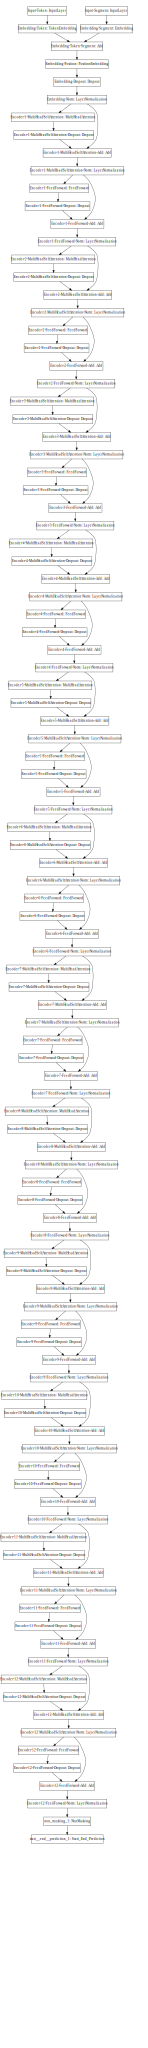

In [88]:
# Bert 의 flow 확인

from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))


In [89]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



훈련 시작

In [0]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
bert_model.summary()
# 훈련 시작
history = bert_model.fit(train_x, train_y, batch_size=12, shuffle=True, verbose=1, epochs=2)

In [0]:
from sklearn.metrics import classification_report
preds = bert_model.predict(train_x)

In [0]:
start_indexes = np.argmax(preds[0], axis=-1)
end_indexes = np.argmax(preds[1], axis=-1)

In [0]:
# start_index의 f1_score 85%
print(classification_report(train_y[0], start_indexes))

# end_index의 f1_score 88%
print(classification_report(train_y[1], end_indexes))

g드라이브 상에 squad 모델을 저장

In [0]:
# 87.7% 79.6%
# 모델 저장하기
path = "gdrive/My Drive/Colab Notebooks/squad"
bert_model.save_weights(path+"/(Uncased)Squad.h5")

In [0]:
# 저장한 bert_model 로드하기
bert_model = get_bert_finetuning_model(model)
path = "gdrive/My Drive/Colab Notebooks/squad"
bert_model.load_weights(path+"/(Uncased)Squad.h5")

버트 모형을 다시 훈련
이번에는 validation_split 을 입력 하지 않아 전체 데이터가 훈련 되도록 만들어 준다.

In [0]:
bert_model.compile(optimizer=RAdam(learning_rate=0.00003, decay=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
bert_model.fit(train_x, train_y, batch_size=10, shuffle=False, verbose=1)

In [0]:
bert_model.save_weights(path+"/(Uncased)Squad2.h5")

Bert 모형을 한번더 훈련 시켜준다. learning_rate 를 0.00001로 변경 

In [0]:
bert_model.compile(optimizer=RAdam(learning_rate=0.00001, decay=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
bert_model.save_weights(path+"/(Uncased)Squad3.h5")

재 사용을 위해 bert_model 을 g드라이브에 저장 

버트 모형을 다시 로드 해준다.

In [0]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights(path+"/squad_wordpiece_3.h5")

Test data set에 대한 bert_input을 만들어 줍니다.  
Train data set과는 다르게 label을 생성하지 않습니다.

In [0]:
def convert_pred_data(question, doc):
    global tokenizer
    indices, segments = [], []
    ids, segment = tokenizer.encode(question, doc, max_len=SEQ_LEN)
    indices.append(ids)
    segments.append(segment)
    indices_x = np.array(indices)
    segments = np.array(segments)
    return [indices_x, segments]

def load_pred_data(question, doc):
    data_x = convert_pred_data(question, doc)
    return data_x

질문과 문장을 받아 답을 알려주는 함수를 정의 

In [0]:
def predict_letter(question, doc):
  
  test_input = load_pred_data(question, doc)
  test_start, test_end = bert_model.predict(test_input)
  
  indexes = tokenizer.encode(question, doc, max_len=SEQ_LEN)[0]
  start = np.argmax(test_start, axis=1).item()
  end = np.argmax(test_end, axis=1).item()
  start_tok = indexes[start]
  end_tok = indexes[end]
  print("Question : ", question)
  
  print("-"*50)
  print("Context : ", end = " ")
  
  def split_text(text, n):
    for line in text.splitlines():
        while len(line) > n:
           x, line = line[:n], line[n:]
           yield x
        yield line

  

  for line in split_text(doc, 150):
    print(line)

  print("-"*50)
  print("ANSWER : ", end = " ")
  print("\n")
  sentences = []
  
  for i in range(start, end+1):
    token_based_word = reverse_token_dict[indexes[i]]
    sentences.append(token_based_word)
    print(token_based_word, end= " ")
  
  print("\n")
  print("Untokenized Answer : ", end = "")
  for w in sentences:
    if w.startswith("##"):
      w = w.replace("##", "")
    else:
      w = " " + w
    
    print(w, end="")
  print("")

In [0]:
def squad_json_to_dataframe_dev(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    main = m[['id','question','context','answers']].set_index('id').reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [0]:
input_file_path ='dev-v1.1.json'
record_path = ['data','paragraphs','qas','answers']
verbose = 0
dev = squad_json_to_dataframe_dev(input_file_path=input_file_path,record_path=record_path)

In [0]:
dev

In [0]:
import random
for i in random.sample(range(100),100):
  doc = dev['context'][i]
  question = dev['question'][i]
  answers = dev['answers'][i]
  predict_letter(question, doc)
  print("")
  print("real answer : ", answers)
  print("")